In [1]:
# Imports
from scipy.io import loadmat
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, completeness_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def p_test(control, treatment, n_perm):
    tobs = np.mean(treatment) - np.mean(control)
    conc = np.concatenate([control, treatment])
    count = 0
    l_split = len(control)
    for _ in range(n_perm):
        perm = np.random.permutation(conc)
        tperm = np.mean(perm[l_split:]) - np.mean(perm[:l_split])
        if tperm > tobs:
            count += 1
    return count/n_perm

In [3]:
# Data is from http://odds.cs.stonybrook.edu/thyroid-disease-dataset/
data = loadmat('./thyroid.mat')
X, y = data['X'], data['y']
# Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)
print(X.shape, y.shape)  # (3772, 6) (3772, 1)

(3772, 6) (3772, 1)


In [4]:
# What do the features look like?
df = pd.DataFrame(data=np.hstack((X, y)), columns=['Feature_%d' % i for i in range(1, X.shape[-1]+1)] + ['y'])
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,y
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,0.0
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,0.0
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,0.0
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,0.0
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature_1  3772 non-null   float64
 1   Feature_2  3772 non-null   float64
 2   Feature_3  3772 non-null   float64
 3   Feature_4  3772 non-null   float64
 4   Feature_5  3772 non-null   float64
 5   Feature_6  3772 non-null   float64
 6   y          3772 non-null   float64
dtypes: float64(7)
memory usage: 206.4 KB


In [6]:
df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,y
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,0.543121,0.008983,0.186826,0.248332,0.376941,0.177301,0.024655
std,0.203790,0.043978,0.070405,0.080579,0.087382,0.054907,0.155093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.376344,0.001132,0.156546,0.203271,0.328638,0.149180,0.000000
50%,0.569892,0.003019,0.190702,0.241822,0.375587,0.173770,0.000000
75%,0.709677,0.004528,0.213472,0.282710,0.413146,0.196721,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All features are scaled between 0--1, so no major preprocessing needed, but for PCA we will need to make sure they're centered at 0.
There are no missing values (as seen from the output of df.info() above).

In [7]:
# How many 'outliers' (y==1) are there?
df['y'].value_counts()

0.0    3679
1.0      93
Name: y, dtype: int64

Data are very imbalanced, so make sure we're stratifying in the next cell when we divide into training and test sets.

In [8]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=10, # always get the same train and test splits
                                                    shuffle=True, stratify=y)
# Train an isolation forest with our training set
clf = IsolationForest(max_samples=100, contamination=0.025, random_state=10)
y_pred_train = clf.fit(X_train).predict(X_train)  # Note that we're not passing the labels for training!
y_pred_test = clf.predict(X_test)  # predict on test set

In [9]:
# We can use PCA to visualise our results
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(std.transform(X_test))

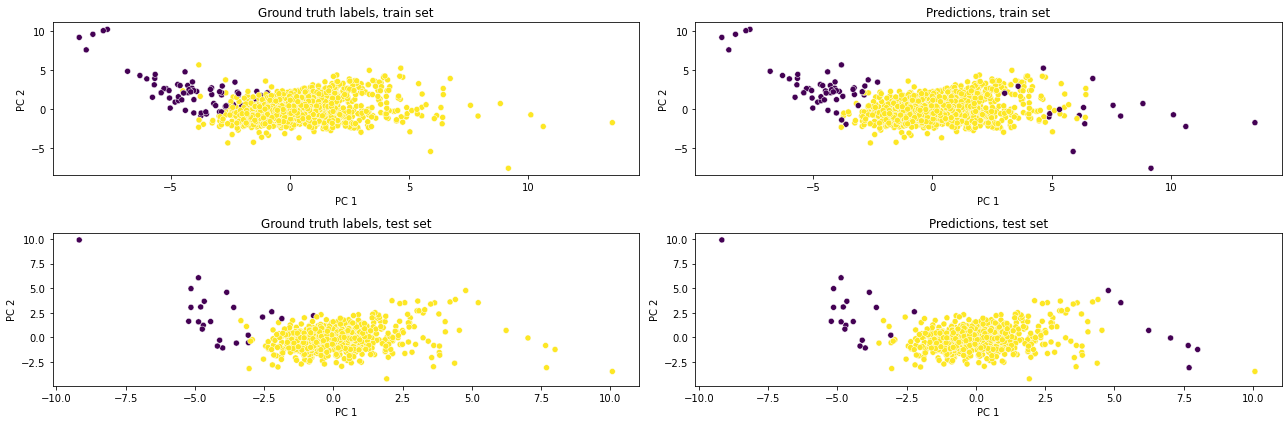

In [10]:
plt.figure(figsize=(18, 6))
plt.subplot(2,2,1)
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], c=2-y_train)  # this is just for plotting purposes
plt.title('Ground truth labels, train set')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.subplot(2,2,2)
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], c=y_pred_train)
plt.title('Predictions, train set')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.subplot(2,2,3)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=2-y_test)  # to make sure colors are consistent in train and test
plt.title('Ground truth labels, test set')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.subplot(2,2,4)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=y_pred_test)
plt.title('Predictions, test set')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.savefig('isolationForests_thyroid.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# We can't use accuracy, but we can use some of the clustering metrics we learnt...
# completeness
print('Completeness: training=%.3f; test=%.3f' % (completeness_score(y_train.reshape(-1), y_pred_train), completeness_score(y_test.reshape(-1), y_pred_test)))
# silhouette score
print('SIL: training=%.3f; test=%.3f' % (silhouette_score(X_train, y_pred_train), silhouette_score(X_test, y_pred_test)))

Completeness: training=0.451; test=0.539
SIL: training=0.430; test=0.418


In [12]:
# Or we can check the average anomaly score for the samples that the original
tr_y, te_y = y_train.reshape(-1), y_test.reshape(-1)
standard_tr, anomaly_tr = clf.score_samples(X_train[tr_y==0]), clf.score_samples(X_train[tr_y==1])
standard_te, anomaly_te = clf.score_samples(X_test[te_y==0]), clf.score_samples(X_test[te_y==1])
print('Average anomaly scores on train set: standard=%.3f; anomaly=%.3f' % (np.mean(standard_tr), np.mean(anomaly_tr)))
print('Average anomaly scores on test set: standard=%.3f; anomaly=%.3f' % (np.mean(standard_te), np.mean(anomaly_te)))

Average anomaly scores on train set: standard=-0.421; anomaly=-0.634
Average anomaly scores on test set: standard=-0.420; anomaly=-0.643


In [13]:
# And do a permutation test: are anomaly scores for anomaly samples larger than for non-anomaly samples?
print('Training set: %.2e' % p_test(-standard_tr, -anomaly_tr, 10000))
print('Test set: %.2e' % p_test(-standard_te, -anomaly_te, 10000))

Training set: 0.00e+00
Test set: 0.00e+00


Tiny p values, meaning that they are clearly separated by our isolation forest.